In [16]:
import json
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import Dict, List, Tuple
from collections import defaultdict
from datasets import load_dataset
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## 1. Load Custom Concept Dataset

In [17]:
# Load concept-to-tags mapping
CONCEPTS = json.load(open("../data/concepts_to_tags.json", "r"))

print("Available concept categories:")
for cat, tags in CONCEPTS.items():
    print(f"  {cat}: {len(tags)} tags (e.g., {tags[:3]})")

Available concept categories:
  tempo: 50 tags (e.g., ['medium tempo', 'slow tempo', 'fast tempo'])
  genre: 50 tags (e.g., ['rock', 'pop', 'electronic music'])
  mood: 50 tags (e.g., ['emotional', 'passionate', 'energetic'])
  instrument: 50 tags (e.g., ['acoustic drums', 'electric guitar', 'bass guitar'])


In [18]:
# Create reverse mapping
TAG_TO_CATEGORY = {}
for cat, tags in CONCEPTS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat

# Define target genres for analysis
TARGET_GENRES = ['rock', 'pop', 'jazz', 'classical', 'electronic', 'hip hop', 'blues', 'metal']
TARGET_GENRES = [g for g in TARGET_GENRES if g in CONCEPTS.get('genre', [])]
print(f"Target genres: {TARGET_GENRES}")

Target genres: ['rock', 'pop', 'jazz', 'classical', 'electronic', 'hip hop', 'blues', 'metal']


In [19]:
def preprocess_audio(audio_array: np.ndarray, sr: int, target_sr: int = 16000, duration: float = 3.0) -> torch.Tensor:
    """Preprocess audio to fixed length and sample rate."""
    # Resample if needed
    if sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=target_sr)
    
    # Trim or pad to fixed duration
    target_length = int(target_sr * duration)
    if len(audio_array) > target_length:
        audio_array = audio_array[:target_length]
    else:
        audio_array = np.pad(audio_array, (0, target_length - len(audio_array)))
    
    return torch.from_numpy(audio_array).float()

In [20]:
# Load GTZAN dataset from local folder
print("Loading GTZAN dataset from local files...")
GTZAN_PATH = Path("../outputs/tta/GTZAN/Data/genres_original")

# Map genre names
GENRE_MAP = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}
TARGET_GENRES = list(GENRE_MAP.keys())

# Load all audio files
print("Scanning audio files...")
audio_files = []
for genre in TARGET_GENRES:
    genre_path = GTZAN_PATH / genre
    wav_files = sorted(genre_path.glob("*.wav"))
    for wav_file in wav_files:
        audio_files.append({
            'path': wav_file,
            'genre': genre,
            'label': GENRE_MAP[genre]
        })

print(f"Loaded {len(audio_files)} audio files")
print(f"Genres: {TARGET_GENRES}")
print(f"Files per genre: ~{len(audio_files) // len(TARGET_GENRES)}")

Loading GTZAN dataset from local files...
Scanning audio files...
Loaded 1000 audio files
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Files per genre: ~100


In [21]:
# Load and preprocess all GTZAN audio
print("Loading and preprocessing GTZAN audio files...")
X_train, y_train = [], []

for file_info in tqdm(audio_files, desc="Loading audio"):
    # Load audio using librosa
    try:
        audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
    except Exception as e:
        print(f"Error loading {file_info['path']}: {e}")
        continue
    
    # Preprocess audio
    audio_tensor = preprocess_audio(audio, sr)
    X_train.append(audio_tensor)
    y_train.append(file_info['label'])

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Sample rate: 16000 Hz, Duration: 3.0 seconds")

Loading and preprocessing GTZAN audio files...


Loading audio:  54%|█████▍    | 542/1000 [00:04<00:03, 123.92it/s]/tmp/ipykernel_87048/3400546144.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading audio:  57%|█████▋    | 569/1000 [00:04<00:03, 123.14it/s]

Error loading ../outputs/tta/GTZAN/Data/genres_original/jazz/jazz.00054.wav: 


Loading audio: 100%|██████████| 1000/1000 [00:08<00:00, 119.66it/s]


Training data shape: torch.Size([999, 48000])
Labels shape: torch.Size([999])
Sample rate: 16000 Hz, Duration: 3.0 seconds


## 2. Load GTZAN Dataset and Train Classifier

In [25]:
class MusicGenreClassifier(pl.LightningModule):
    """Simple CNN-based music genre classifier."""
    
    def __init__(self, num_genres: int = 10, lr: float = 0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=400, hop_length=160, n_mels=64
        )
        
        # CNN feature extractor
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Bottleneck layer (for TCAV)
        self.bottleneck = torch.nn.Linear(128, 256)
        self.classifier = torch.nn.Linear(256, num_genres)
        self.relu = torch.nn.ReLU()
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, x: torch.Tensor, return_bottleneck: bool = True):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Convert to mel-spectrogram
        if x.shape[1] == 1 and x.shape[2] > 1000:
            x = self.mel_spectrogram(x)
            x = torchaudio.transforms.AmplitudeToDB()(x)
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        bottleneck = self.bottleneck(x)
        x = self.relu(bottleneck)
        logits = self.classifier(x)
        
        if return_bottleneck:
            return logits, bottleneck
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, return_bottleneck=False)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, return_bottleneck=False)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

# Initialize model
model = MusicGenreClassifier(num_genres=len(TARGET_GENRES), lr=0.001)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

Model params: 128,714


In [26]:
# Train the classifier
print("Training genre classifier on GTZAN...")

# Split data
indices = torch.randperm(len(X_train))
train_size = int(0.8 * len(X_train))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

X_train_split = X_train[train_indices]
y_train_split = y_train[train_indices]
X_val = X_train[val_indices]
y_val = y_train[val_indices]

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)

# Setup trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor='val_acc',
            mode='max',
            filename='best-genre-classifier-{epoch:02d}-{val_acc:.2f}'
        ),
        pl.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        )
    ],
)

# Train
trainer.fit(model, train_loader, val_loader)

print("✓ Model training complete!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | mel_spectrogram | MelSpectrogram   | 0      | train
1 | features        | Sequential       | 93.1 K | train
2 | bottleneck      | Linear           | 33.0 K | train
3 | classifier      | Linear           | 2.6 K  | train
4 | relu            | ReLU             | 0      | train
5 | criterion       | CrossEntropyLoss | 0      | train
-------------------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.515     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Training genre classifier on GTZAN...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


✓ Model training complete!


## 3. Load Real Audio from Dataset

In [27]:
# Load generated audio dataset from local files
print("Loading generated audio dataset from local files...")

# Load metadata from per_sample_scores.csv
AUDIO_DATA_PATH = Path("../outputs/tta/subset")
metadata_df = pd.read_csv(AUDIO_DATA_PATH / "per_sample_scores.csv")

# Parse aspect_list column (it's stored as string representation of list)
import ast
metadata_df['aspect_list_parsed'] = metadata_df['aspect_list'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else []
)

print(f"Loaded {len(metadata_df)} audio samples")
print(f"Audio files location: {AUDIO_DATA_PATH / 'audio_samples'}")
print(f"\nSample aspects: {metadata_df['aspect_list_parsed'].iloc[0][:5]}...")

def get_audio_by_tags(tags: List[str], num_samples: int) -> List[torch.Tensor]:
    """Load real audio samples that match given tags."""
    samples = []
    
    # Filter by aspect list
    matching_indices = []
    for idx, row in metadata_df.iterrows():
        aspect_list = row['aspect_list_parsed']
        if any(tag in aspect_list for tag in tags):
            matching_indices.append(idx)
            if len(matching_indices) >= num_samples:
                break
    
    # Load audio files
    for idx in matching_indices[:num_samples]:
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            audio, sr = librosa.load(audio_path, sr=None, mono=True)
            audio_tensor = preprocess_audio(audio, sr)
            samples.append(audio_tensor)
    
    # If not enough samples, pad with random ones
    while len(samples) < num_samples:
        idx = np.random.randint(0, len(metadata_df))
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            audio, sr = librosa.load(audio_path, sr=None, mono=True)
            audio_tensor = preprocess_audio(audio, sr)
            samples.append(audio_tensor)
    
    return samples[:num_samples]


def create_concept_dataset_from_audio(concepts: List[str], num_samples: int = 20) -> torch.Tensor:
    """Create dataset from real audio matching concept tags."""
    samples = get_audio_by_tags(concepts, num_samples)
    return torch.stack(samples)


def create_random_audio_dataset(num_samples: int = 30) -> torch.Tensor:
    """Create random audio samples from dataset."""
    samples = []
    indices = np.random.choice(len(metadata_df), min(num_samples, len(metadata_df)), replace=False)
    
    for idx in indices:
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            audio, sr = librosa.load(audio_path, sr=None, mono=True)
            audio_tensor = preprocess_audio(audio, sr)
            samples.append(audio_tensor)
    
    return torch.stack(samples)

print("Audio loading functions defined.")

Loading generated audio dataset from local files...
Loaded 500 audio samples
Audio files location: ../outputs/tta/subset/audio_samples

Sample aspects: ['acoustic guitar', 'classical', 'classical music', 'drums', 'flute']...
Audio loading functions defined.


## 4. TCAV Implementation

In [31]:
class TCAV:
    """Testing with Concept Activation Vectors."""
    
    def __init__(self, model: torch.nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
    
    def get_activations(self, audio: torch.Tensor) -> np.ndarray:
        """Extract bottleneck activations."""
        audio = audio.to(self.device)
        with torch.no_grad():
            _, bottleneck = self.model(audio)
        return bottleneck.cpu().numpy()
    
    def train_cav(self, concept_acts: np.ndarray, random_acts: np.ndarray, 
                  num_runs: int = 5) -> Dict:
        """Train CAV (Concept Activation Vector) using logistic regression."""
        cavs, scores = [], []
        
        for run in range(num_runs):
            X = np.vstack([concept_acts, random_acts])
            y = np.hstack([np.ones(len(concept_acts)), np.zeros(len(random_acts))])
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=run
            )
            
            clf = LogisticRegression(max_iter=1000, random_state=run)
            clf.fit(X_train, y_train)
            
            cav = clf.coef_[0]
            cav = cav / (np.linalg.norm(cav) + 1e-8)
            
            cavs.append(cav)
            scores.append(accuracy_score(y_test, clf.predict(X_test)))
        
        return {
            'cav': np.mean(cavs, axis=0),
            'accuracy': np.mean(scores),
            'accuracy_std': np.std(scores)
        }
    
    def compute_tcav_score(self, activations: np.ndarray, cav: np.ndarray) -> float:
        """Compute TCAV score (fraction with positive sensitivity)."""
        sensitivities = np.dot(activations, cav)
        return np.mean(sensitivities > 0)

tcav = TCAV(model, device)
print("TCAV analyzer initialized.")

TCAV analyzer initialized.


## 5. Run TCAV Analysis

In [32]:
# Analyze what aspects are actually present in the dataset
all_aspects = set()
for aspects in metadata_df['aspect_list_parsed']:
    all_aspects.update(aspects)

print(f"Total unique aspects in dataset: {len(all_aspects)}")
print(f"Sample aspects: {sorted(list(all_aspects))[:20]}")

# Define concepts to analyze based on what's in the dataset
ANALYSIS_CONCEPTS = {
    'tempo': ['fast tempo', 'slow tempo', 'medium tempo', 'uptempo'],
    'instrument': ['guitar', 'piano', 'drums', 'e-guitar', 'acoustic guitar', 'bass', 'e-bass'],
    'mood': ['emotional', 'energetic', 'passionate', 'soulful', 'aggressive', 'ambient'],
    'style': ['rock', 'pop', 'blues', 'folk', 'techno']
}

# Filter to concepts that exist in our dataset
for cat in list(ANALYSIS_CONCEPTS.keys()):
    existing_concepts = [c for c in ANALYSIS_CONCEPTS[cat] if c in all_aspects]
    if existing_concepts:
        ANALYSIS_CONCEPTS[cat] = existing_concepts
    else:
        del ANALYSIS_CONCEPTS[cat]

# Concept mapping for variations
CONCEPT_TO_VARIANTS = {
    'guitar': ['guitar', 'acoustic guitar', 'e-guitar'],
    'piano': ['piano', 'keyboard'],
    'drums': ['drums', 'percussion', 'acoustic drums', 'digital drums', 'electronic drums'],
    'bass': ['bass', 'e-bass'],
    'energetic': ['energetic', 'upbeat'],
    'emotional': ['emotional', 'passionate', 'soulful'],
    'fast tempo': ['fast tempo', 'uptempo'],
    'slow tempo': ['slow tempo', 'medium tempo']
}

print("\nConcepts for analysis:")
for cat, concepts in ANALYSIS_CONCEPTS.items():
    print(f"  {cat}: {concepts}")

Total unique aspects in dataset: 177
Sample aspects: ['acoustic drums', 'acoustic guitar', 'afrobeats', 'aggressive', 'alternative rock', 'ambient', 'ambient noises', 'ambient sounds', 'ballad', 'bass', 'bass guitar', 'beat boxing', 'blues', 'calm', 'calming', 'cello', 'chaotic', 'cheerful', 'chill', 'cinematic']

Concepts for analysis:
  tempo: ['fast tempo', 'slow tempo', 'medium tempo', 'uptempo']
  instrument: ['guitar', 'piano', 'drums', 'e-guitar', 'acoustic guitar', 'bass', 'e-bass']
  mood: ['emotional', 'energetic', 'passionate', 'soulful', 'aggressive', 'ambient']
  style: ['rock', 'pop', 'blues', 'folk', 'techno']


In [33]:
# Generate random counterexamples from real audio
random_data = create_random_audio_dataset(num_samples=50)
random_acts = tcav.get_activations(random_data)

# Run TCAV analysis
results = defaultdict(dict)

print("\n" + "="*60)
print("TCAV ANALYSIS RESULTS")
print("="*60)

for category, concept_list in ANALYSIS_CONCEPTS.items():
    print(f"\n📊 Category: {category.upper()}")
    print("-" * 40)
    
    for concept in concept_list:
        # Get concept variants
        search_tags = CONCEPT_TO_VARIANTS.get(concept, [concept])
        
        # Load real audio for concept
        print(f"  Loading audio for '{concept}'...")
        concept_data = create_concept_dataset_from_audio(search_tags, num_samples=30)
        concept_acts = tcav.get_activations(concept_data)
        
        # Train CAV
        cav_result = tcav.train_cav(concept_acts, random_acts, num_runs=5)
        
        # Compute TCAV scores for each genre using GTZAN samples
        genre_scores = {}
        for genre_name in TARGET_GENRES:
            # Get GTZAN samples for this genre
            genre_idx = GENRE_MAP[genre_name]
            genre_mask = y_train == genre_idx
            genre_samples = X_train[genre_mask][:20]  # Take first 20 samples
            
            genre_acts = tcav.get_activations(genre_samples)
            genre_scores[genre_name] = tcav.compute_tcav_score(genre_acts, cav_result['cav'])
        
        results[category][concept] = {
            'cav_accuracy': cav_result['accuracy'],
            'genre_scores': genre_scores
        }
        
        print(f"  {concept}: CAV acc={cav_result['accuracy']:.3f}")

print("\n" + "="*60)
print("✓ Analysis complete")


TCAV ANALYSIS RESULTS

📊 Category: TEMPO
----------------------------------------
  Loading audio for 'fast tempo'...
  fast tempo: CAV acc=0.417
  Loading audio for 'slow tempo'...
  slow tempo: CAV acc=0.375
  Loading audio for 'medium tempo'...
  medium tempo: CAV acc=0.433
  Loading audio for 'uptempo'...
  uptempo: CAV acc=0.400

📊 Category: INSTRUMENT
----------------------------------------
  Loading audio for 'guitar'...
  guitar: CAV acc=0.400
  Loading audio for 'piano'...
  piano: CAV acc=0.367
  Loading audio for 'drums'...
  drums: CAV acc=0.458
  Loading audio for 'e-guitar'...
  e-guitar: CAV acc=0.450
  Loading audio for 'acoustic guitar'...
  acoustic guitar: CAV acc=0.425
  Loading audio for 'bass'...
  bass: CAV acc=0.408
  Loading audio for 'e-bass'...
  e-bass: CAV acc=0.383

📊 Category: MOOD
----------------------------------------
  Loading audio for 'emotional'...
  emotional: CAV acc=0.475
  Loading audio for 'energetic'...
  energetic: CAV acc=0.417
  Loading

## 6. Visualize Results

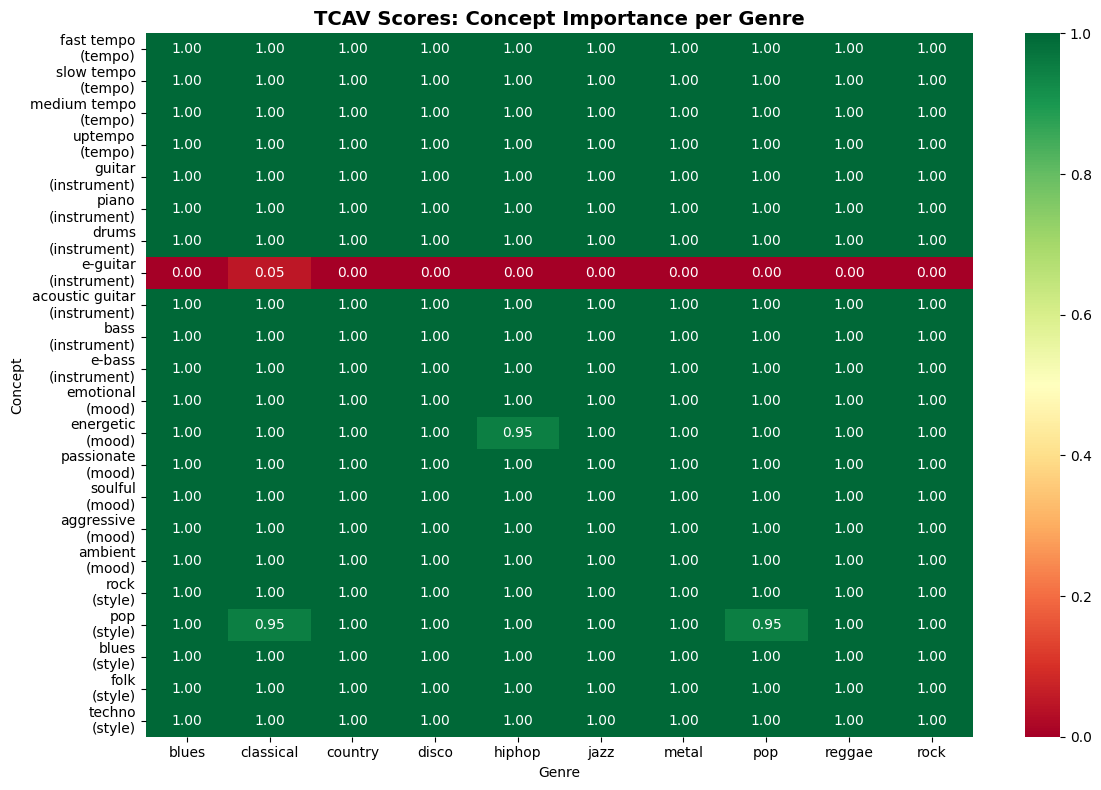

In [34]:
# Create TCAV scores heatmap
all_concepts = [c for concepts in ANALYSIS_CONCEPTS.values() for c in concepts]

# Build score matrix
score_matrix = []
concept_names = []

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        scores = [data['genre_scores'].get(g, 0.5) for g in TARGET_GENRES]
        score_matrix.append(scores)
        concept_names.append(f"{concept}\n({category})")

score_matrix = np.array(score_matrix)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    score_matrix, 
    xticklabels=TARGET_GENRES,
    yticklabels=concept_names,
    annot=True, 
    fmt='.2f',
    cmap='RdYlGn',
    vmin=0, vmax=1,
    ax=ax
)
ax.set_title('TCAV Scores: Concept Importance per Genre', fontsize=14, fontweight='bold')
ax.set_xlabel('Genre')
ax.set_ylabel('Concept')
plt.tight_layout()
plt.show()

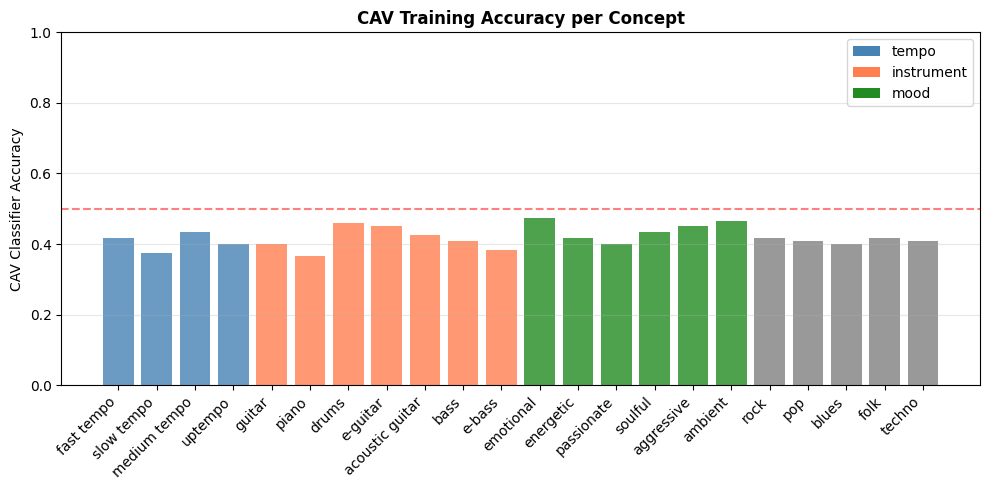

In [35]:
# Plot CAV classifier accuracies
fig, ax = plt.subplots(figsize=(10, 5))

accuracies = []
labels = []
colors = []
color_map = {'tempo': 'steelblue', 'instrument': 'coral', 'mood': 'forestgreen'}

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        accuracies.append(data['cav_accuracy'])
        labels.append(concept)
        colors.append(color_map.get(category, 'gray'))

bars = ax.bar(range(len(accuracies)), accuracies, color=colors, alpha=0.8)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('CAV Classifier Accuracy')
ax.set_title('CAV Training Accuracy per Concept', fontweight='bold')
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random baseline')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=cat) for cat, c in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [36]:
# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

for category, concept_dict in results.items():
    print(f"\n{category.upper()}:")
    for concept, data in concept_dict.items():
        scores = list(data['genre_scores'].values())
        print(f"  {concept}:")
        print(f"    CAV Accuracy: {data['cav_accuracy']:.3f}")
        print(f"    TCAV Score Range: [{min(scores):.3f}, {max(scores):.3f}]")
        print(f"    Mean TCAV Score: {np.mean(scores):.3f}")


SUMMARY STATISTICS

TEMPO:
  fast tempo:
    CAV Accuracy: 0.417
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  slow tempo:
    CAV Accuracy: 0.375
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  medium tempo:
    CAV Accuracy: 0.433
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  uptempo:
    CAV Accuracy: 0.400
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000

INSTRUMENT:
  guitar:
    CAV Accuracy: 0.400
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  piano:
    CAV Accuracy: 0.367
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  drums:
    CAV Accuracy: 0.458
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  e-guitar:
    CAV Accuracy: 0.450
    TCAV Score Range: [0.000, 0.050]
    Mean TCAV Score: 0.005
  acoustic guitar:
    CAV Accuracy: 0.425
    TCAV Score Range: [1.000, 1.000]
    Mean TCAV Score: 1.000
  bass:
    CAV Accuracy: 0.408
    TCAV Score Range: